# Multivariate time-series models

Multivariate time-series models are designed to capture the dynamic of multiple time series simultaneously and leverage dependencies across these series for more reliable predictions.

In economics, multivariate time series are used to understand how policy changes to one variable, such as an interest rate, may affect other variables over different horizons.

The impulse-response function produced by the multivariate model serves this purpose and allows us to simulate how one variable responds to a sudden change in other variables. 

The concept of Granger causality analyzes whether one variable is useful in forecasting another (in the least-squares sense).
Furthermore, multivariate time-series models allow for a decomposition of the prediction error variance to analyze how other series contribute.

# The vector autoregressive (VAR) model

We will see how the vector autoregressive VAR(p) model extends the AR(p) model to k series by creating a system of k equations, where each contains p lagged values of all k series. In the simplest case, a VAR(1) model for k=2 takes the following form:
$$
\begin{aligned}
   y_{1,t}&=c_1+\alpha_{1,1}y_{1,t-1}+\alpha_{1,2}y_{2,t-1}+\epsilon_{1,t}\\
   y_{2,t}&=c_2+\alpha_{2,1}y_{1,t-1}+\alpha_{2,2}y_{2,t-1}+\epsilon_{2,t}
\end{aligned}
$$
This model can be expressed somewhat more concisely in matrix form:
$$
\begin{bmatrix}
    y_{1,t}\\
    y_{2,t}
\end{bmatrix}=
\begin{bmatrix}
    c_1\\
    c_2
\end{bmatrix}+
\begin{bmatrix}
    a_{1,1} & a_{1,2}\\
    a_{2,1} & a_{2,2} 
\end{bmatrix}
\begin{bmatrix}
    y_{1,t-1}\\
    y_{2,t-2}
\end{bmatrix}+
\begin{bmatrix}
   \epsilon_{1,t}\\
   \epsilon_{2,t}
\end{bmatrix}
$$
The coefficients on the lagged values of the output provide information about the dynamics of the series itself, whereas the cross-variable coefficients offer some insight into the interactions across the series. This notation extends to k time series and order p, as follows:
$$
\mathop{y_t}\limits_{k\times 1}=\mathop{c}\limits_{k\times 1}+
\mathop{A_1}\limits_{k\times k}\mathop{y_{t-1}}\limits_{k\times 1}+\cdots+
\mathop{A_p}\limits_{k\times k}\mathop{y_{t-p}}\limits_{k\times 1}+
\mathop{\epsilon_t}\limits_{k\times 1}
$$

VAR(p) models also require stationarity so that the initial steps from univariate time-series modeling carry over. First, explore the series and determine the necessary transformations. Then, apply the augmented Dickey-Fuller test to verify that the stationarity criterion is met for each series and apply further transformations otherwise. It can be estimated with an OLS conditional on initial information or with MLE, which is the equivalent for normally distributed errors but not otherwise.

If some or all of the k series are unit-root non-stationary, they may be cointegrated (see the next section). This extension of the unit root concept to multiple time series means that a linear combination of two or more series is stationary and, hence, mean-reverting.

The VAR model is not equipped to handle this case without differencing; instead, use the vector error correction model (VECM, Johansen and Juselius 1990). We will further explore cointegration because, if present and assumed to persist, it can be leveraged for a pairs-trading strategy.

The determination of the lag order also takes its cues from the ACF and PACF for each series, but is constrained by the fact that the same lag order applies to all series. After model estimation, residual diagnostics also call for a result resembling white noise, and model selection can use in-sample information criteria or, if the goal is to use the model for prediction, out-of-sample predictive performance to cross-validate alternative model designs.

As mentioned in the univariate case, predictions of the original time series require us to reverse the transformations applied to make a series stationary before training the model.

# How to use the VAR model for macro fundamentals forecasts

The vector autoregressive VAR(p) model extends the AR(p) model to k series by creating a system of k equations where each contains p lagged values of all k series. The coefficients on the own lags provide information about the dynamics of the series itself, whereas the cross-variable coefficients offer some insight into the interactions across the series.

## Imports and Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sns

from statsmodels.tsa.api import VARMAX
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import minmax_scale
from scipy.stats import probplot, moment
from sklearn.metrics import mean_absolute_error

In [3]:
sns.set(style='whitegrid',
        context='notebook',
        color_codes=True)

## Helper Functions

### Correlogram Plot

In [4]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Time Series')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

### Unit Root Test

In [5]:
def test_unit_root(df):
    return df.apply(lambda x: f'{pd.Series(adfuller(x)).iloc[1]:.2%}').to_frame('p-value')

## Load Data

We will extend the univariate example of a single time series of monthly data on industrial production and add a monthly time series on consumer sentiment, both provided by the Federal Reserve's data service. We will use the familiar pandas-datareader library to retrieve data from 1972 through 2019:

In [6]:
sent = 'UMCSENT'
df = web.DataReader(['UMCSENT', 'IPGMFN'], 'fred', '1970', '2019-12').dropna()
df.columns = ['sentiment', 'ip']

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 528 entries, 1972-02-01 to 2019-12-01
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sentiment  528 non-null    float64
 1   ip         528 non-null    float64
dtypes: float64(2)
memory usage: 12.4 KB


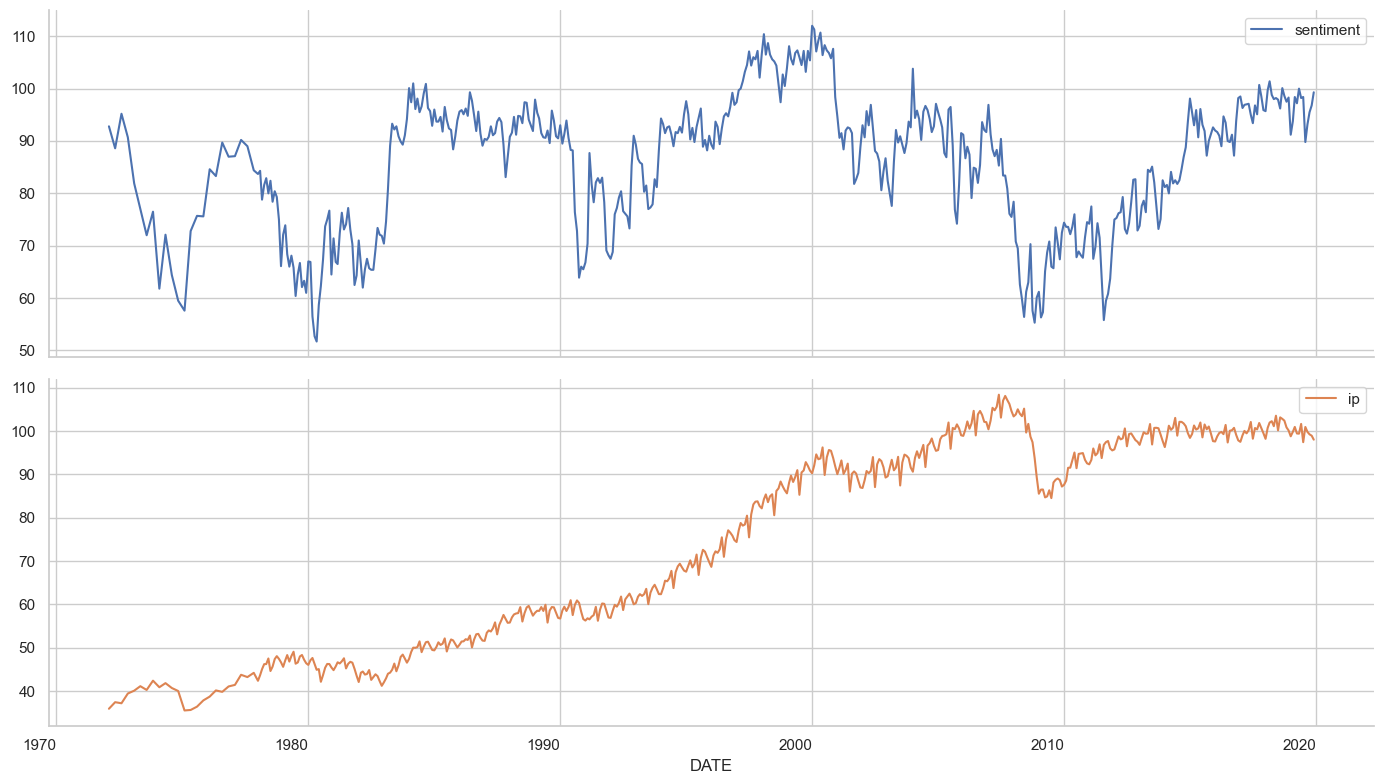

In [8]:
df.plot(subplots=True, figsize=(14,8), rot=0)
sns.despine()
plt.tight_layout();

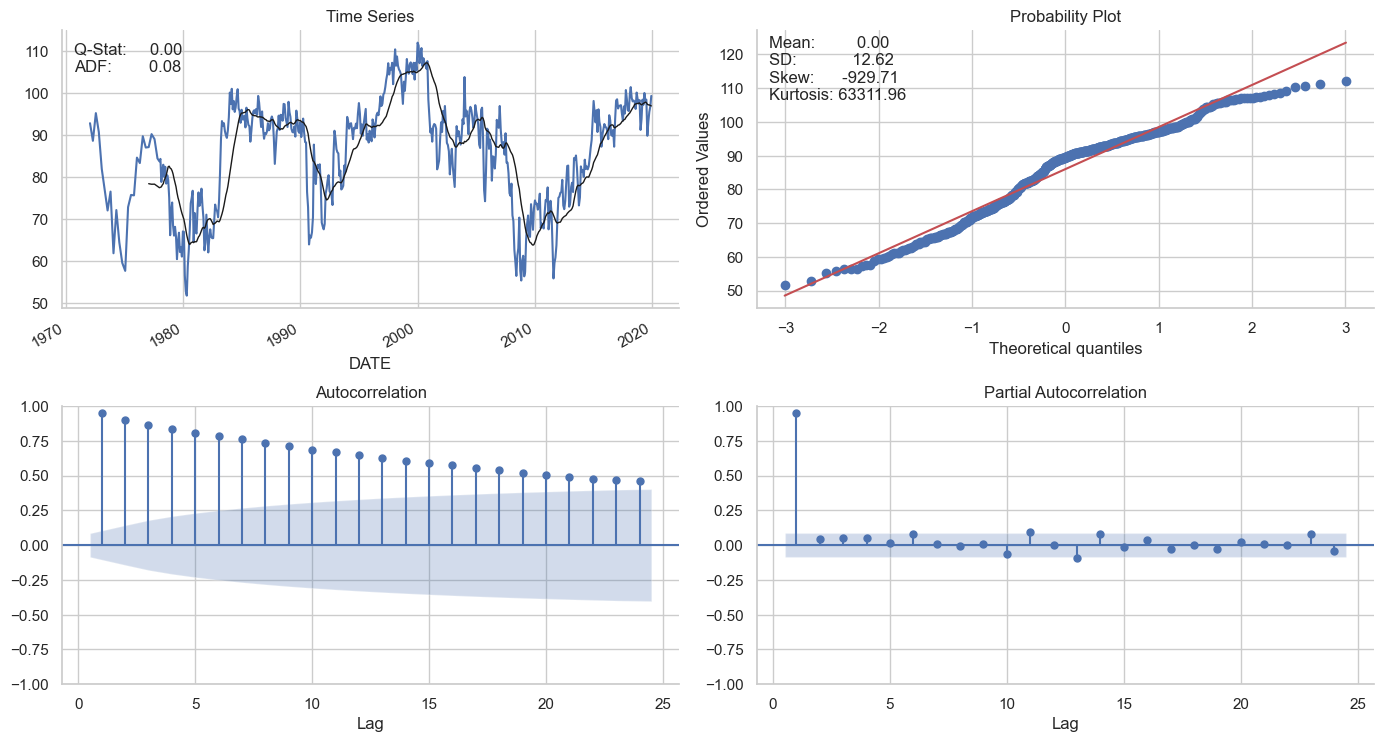

In [9]:
plot_correlogram(df.sentiment, lags=24)

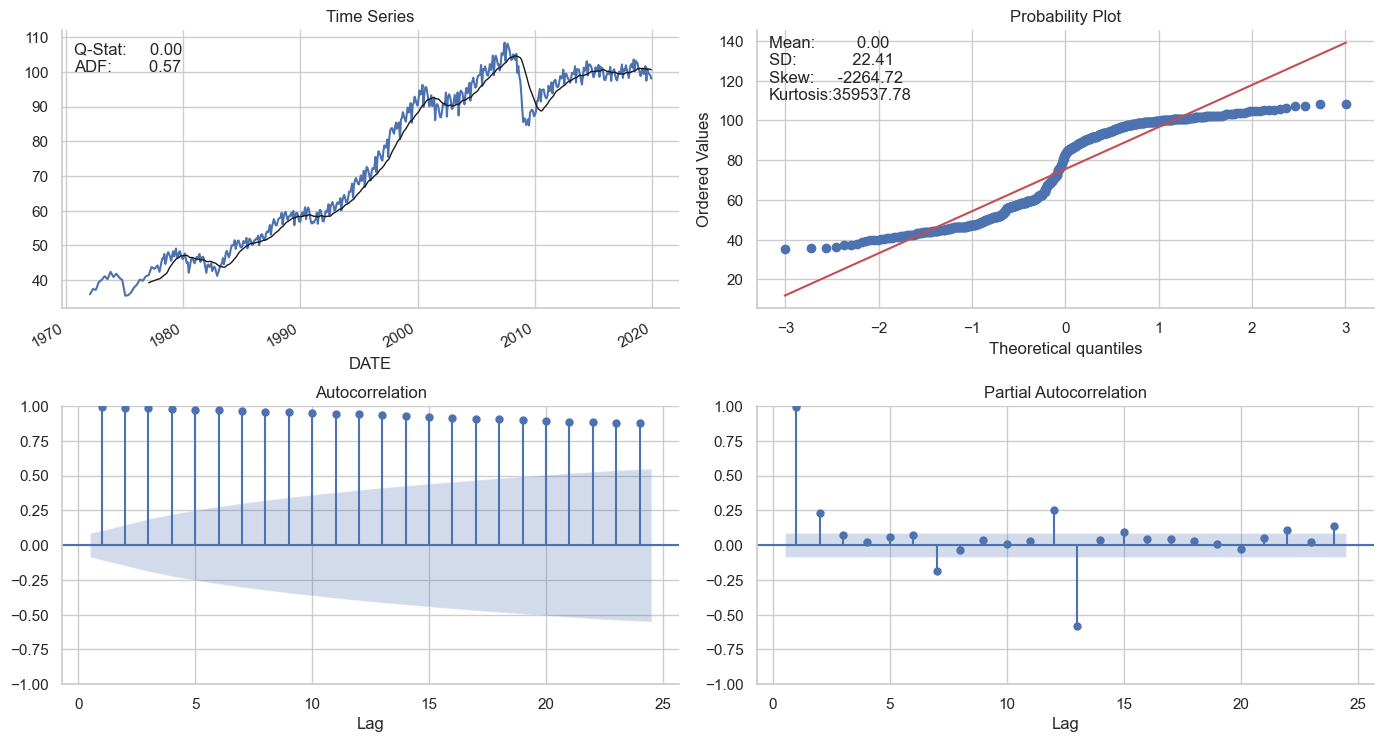

In [10]:
plot_correlogram(df.ip, lags=24)

## Stationarity Transform

In [11]:
df_transformed = pd.DataFrame({'ip': np.log(df.ip).diff(12),
                              'sentiment': df.sentiment.diff(12)}).dropna()

## Inspect Correlograms

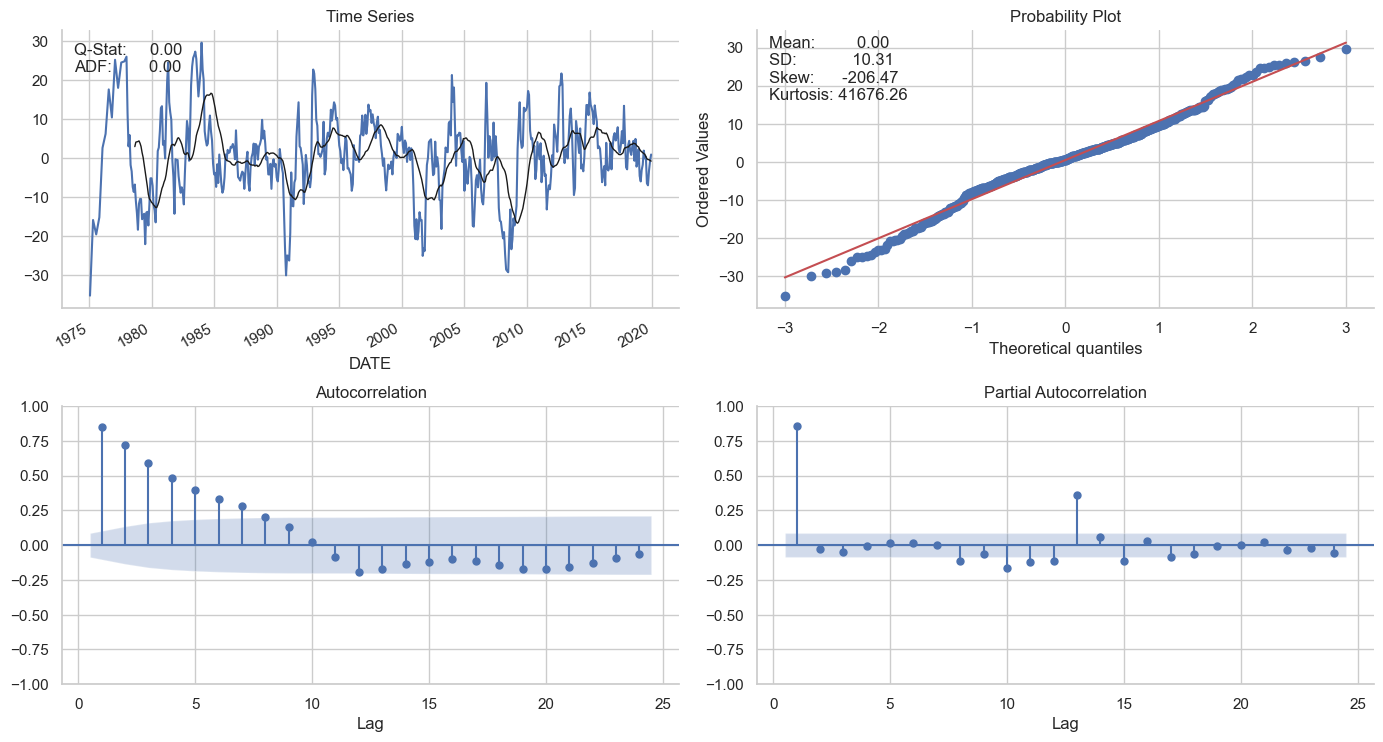

In [12]:
plot_correlogram(df_transformed.sentiment, lags=24)

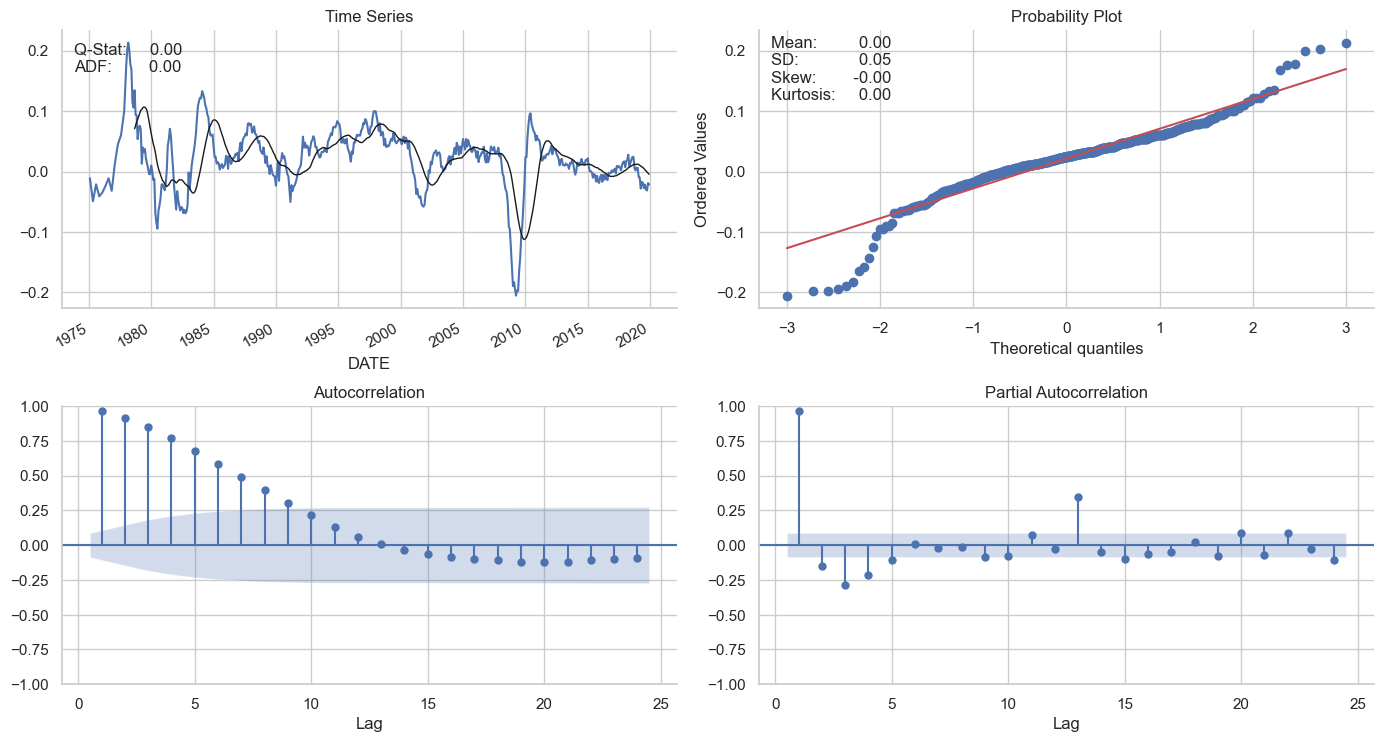

In [13]:
plot_correlogram(df_transformed.ip, lags=24)

In [14]:
test_unit_root(df_transformed)

,p-value
ip,0.02%
sentiment,0.00%


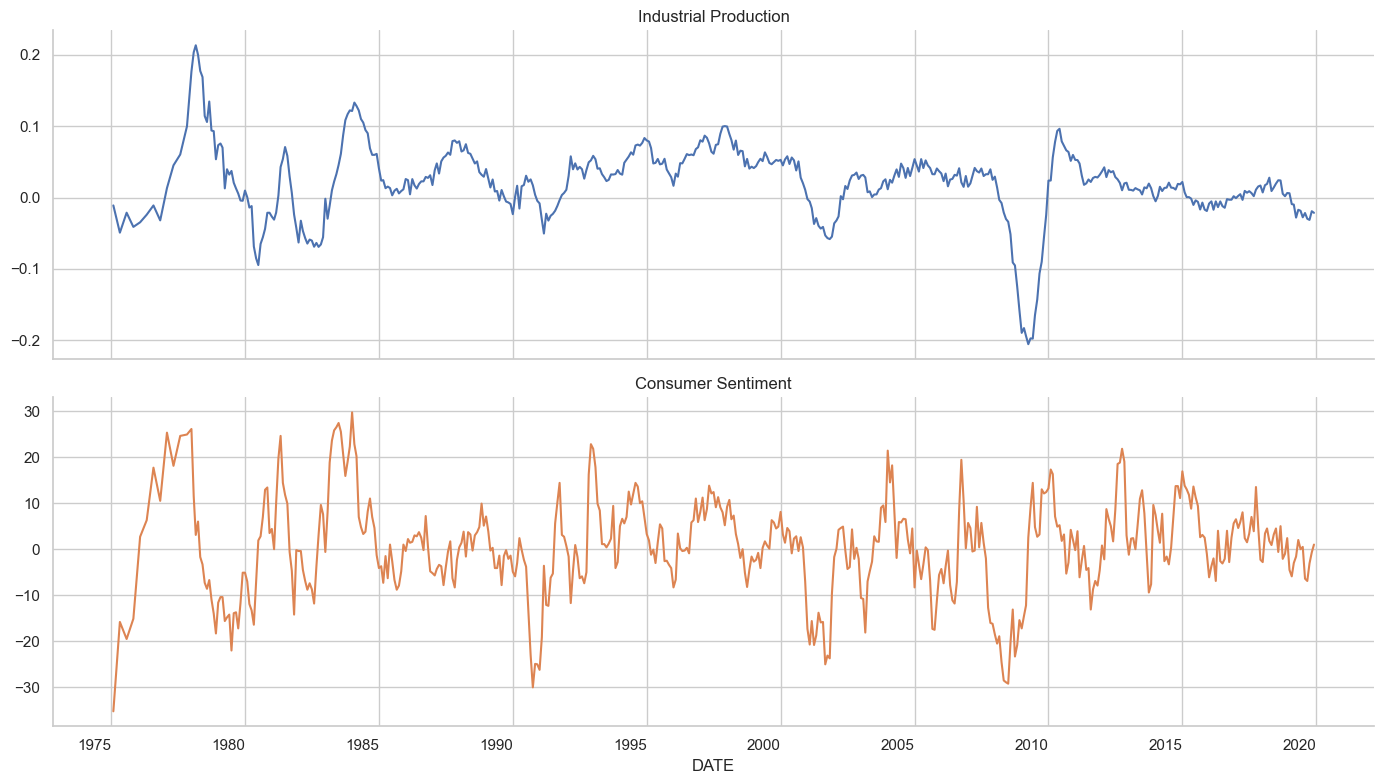

In [15]:
df_transformed.plot(subplots=True, figsize=(14, 8),
                    title=['Industrial Production', 'Consumer Sentiment'],
                    legend=False,
                    rot=0)
sns.despine()
plt.tight_layout()

## VAR Model

To limit the size of the output, we will just estimate a VAR(1) model using the statsmodels VARMAX implementation (which allows for optional exogenous variables) with a constant trend through 2017. The output contains the coefficients for both time series equations.

In [16]:
df_transformed = df_transformed.apply(minmax_scale)

In [17]:
model = VARMAX(df_transformed.loc[:'2017'], order=(1,1), trend='c').fit(maxiter=1000)

D:\anaconda3\envs\quant38\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
D:\anaconda3\envs\quant38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [18]:
print(model.summary())

                            Statespace Model Results                           
Dep. Variable:     ['ip', 'sentiment']   No. Observations:                  492
Model:                      VARMA(1,1)   Log Likelihood                1557.375
                           + intercept   AIC                          -3088.750
Date:                 Thu, 24 Nov 2022   BIC                          -3034.170
Time:                         16:36:44   HQIC                         -3067.318
Sample:                              0                                         
                                 - 492                                         
Covariance Type:                   opg                                         
Ljung-Box (L1) (Q):             0.23, 0.42   Jarque-Bera (JB):        151.58, 16.68
Prob(Q):                        0.63, 0.52   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.46, 1.02   Skew:                       0.19, 0.21
Prob(H) (two-sided):        

### Plot Diagnostics

`statsmodels` provides diagnostic plots to check whether the residuals meet the white noise assumptions, which are not exactly met in this simple case:

#### Industrial Production

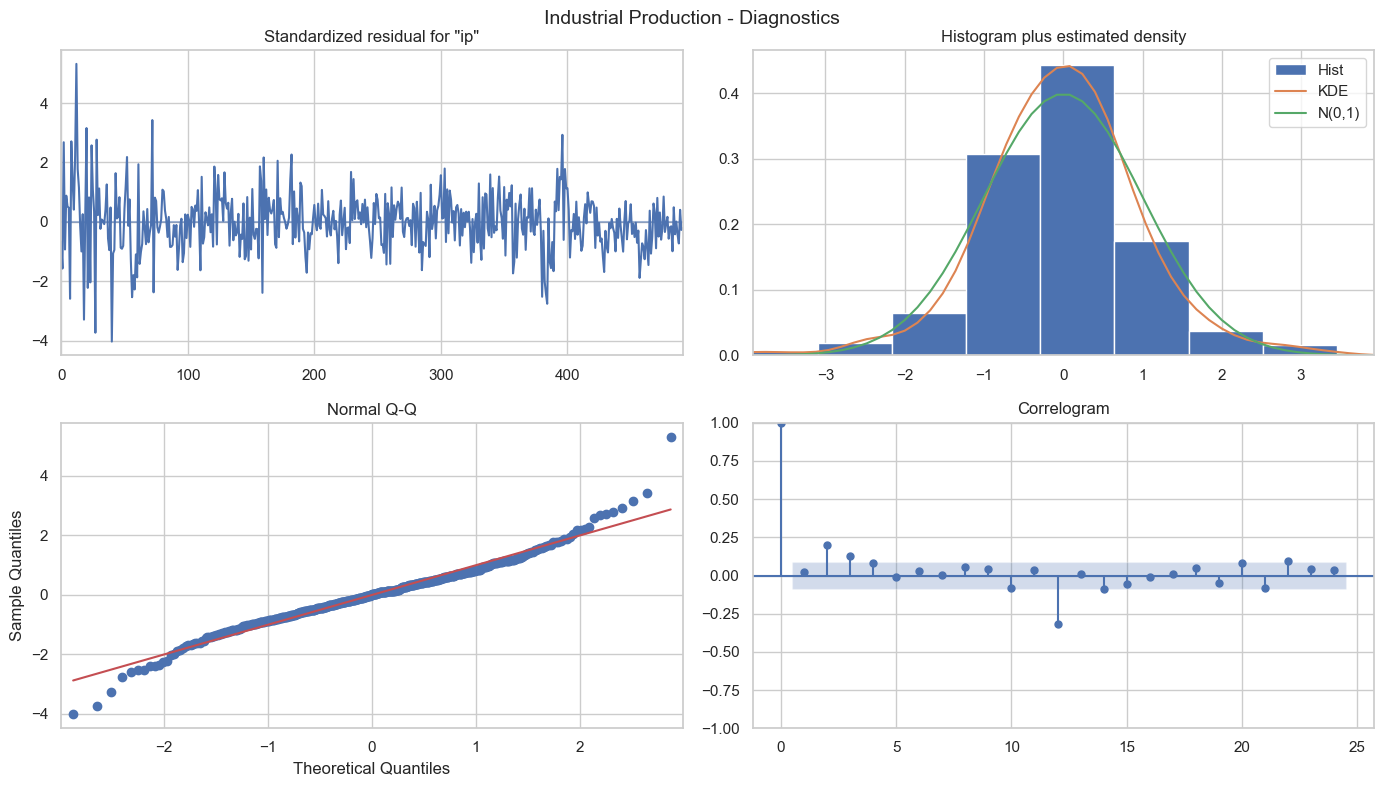

In [19]:
model.plot_diagnostics(variable=0, figsize=(14,8), lags=24)
plt.gcf().suptitle('Industrial Production - Diagnostics', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=.93);

#### Sentiment

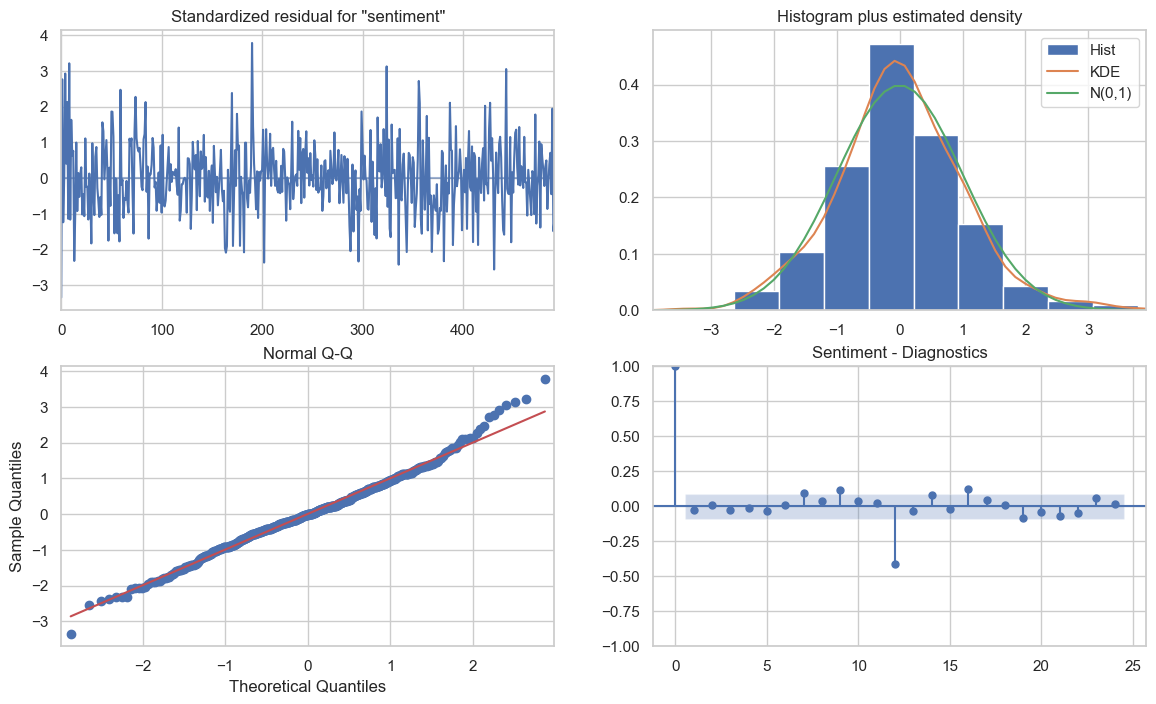

In [20]:
model.plot_diagnostics(variable=1, figsize=(14,8), lags=24)
plt.title('Sentiment - Diagnostics');

### Impulse-Response Function

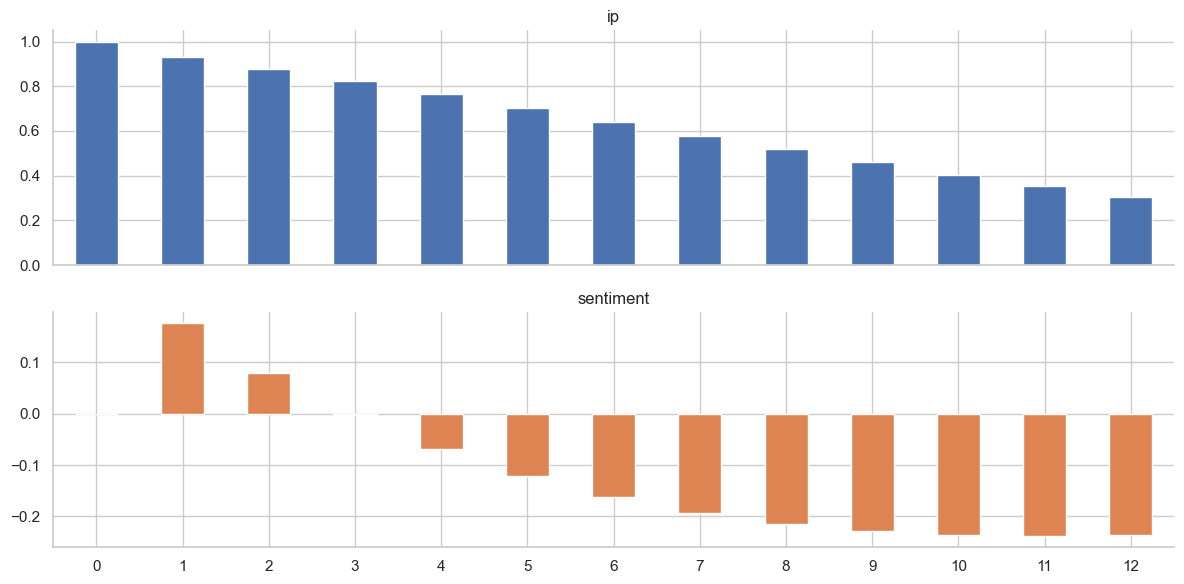

In [22]:
median_change = df_transformed.diff().quantile(.5).tolist()
model.impulse_responses(steps=12,impulse=[1,0]).plot.bar(subplots=True,
                                            figsize=(12, 6),
                                            rot=0,
                                            legend=False)
sns.despine()
plt.tight_layout()

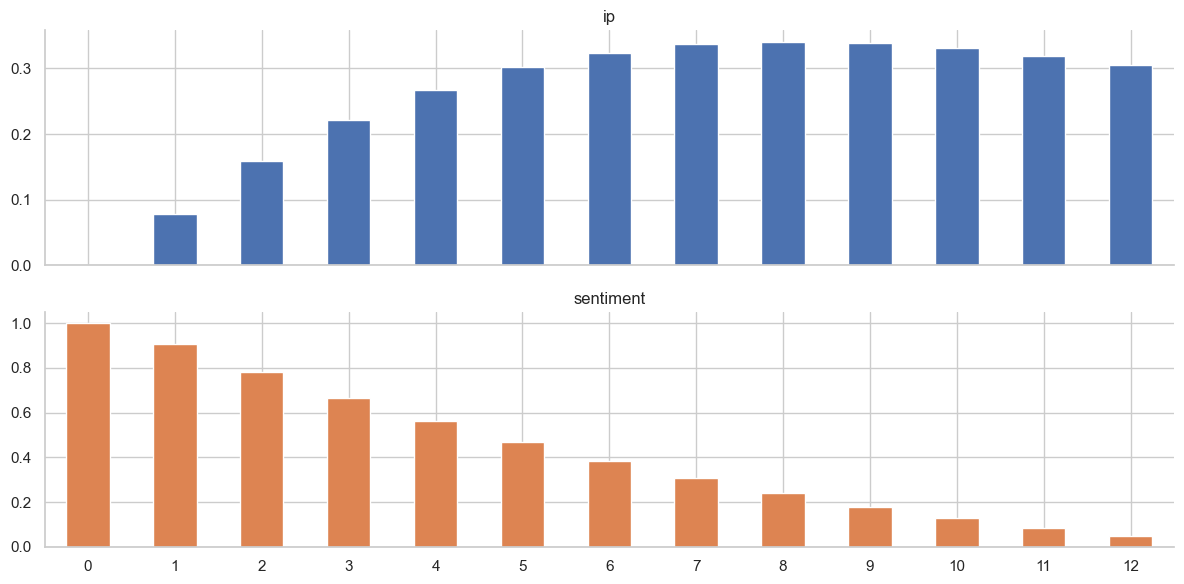

In [21]:
median_change = df_transformed.diff().quantile(.5).tolist()
model.impulse_responses(steps=12,impulse=[0,1]).plot.bar(subplots=True,
                                            figsize=(12, 6),
                                            rot=0,
                                            legend=False)
sns.despine()
plt.tight_layout()

### Generate Predictions

Out-of-sample predictions can be generated as follows:

In [23]:
n =len(df_transformed)
start = n-24

preds = model.predict(start=start+1, end=n)

D:\anaconda3\envs\quant38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


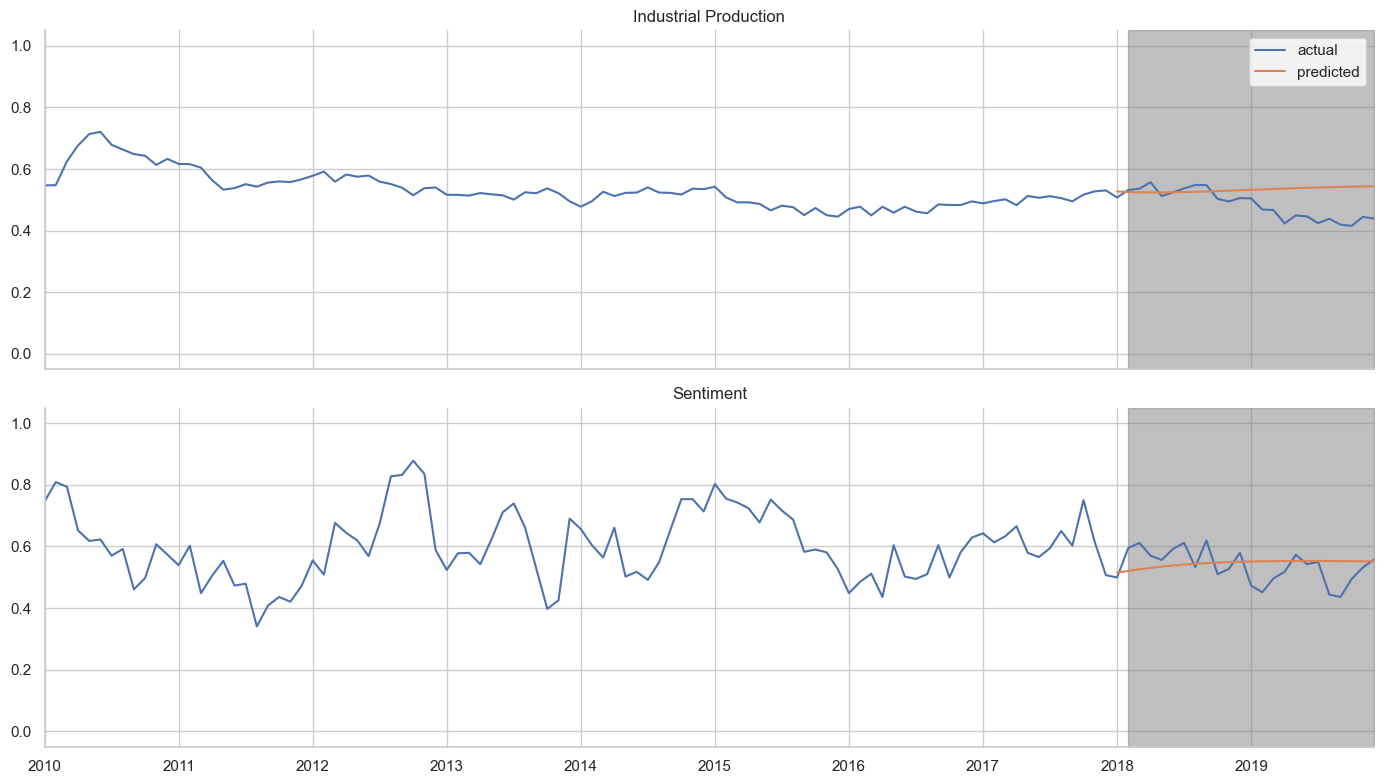

In [24]:
preds.index = df_transformed.index[start:]

fig, axes = plt.subplots(nrows=2, figsize=(14, 8), sharex=True)

df_transformed.ip.loc['2010':].plot(ax=axes[0], label='actual', title='Industrial Production')
preds.ip.plot(label='predicted', ax=axes[0])
trans = mtransforms.blended_transform_factory(axes[0].transData, axes[0].transAxes)
axes[0].legend()
axes[0].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)

trans = mtransforms.blended_transform_factory(axes[0].transData, axes[1].transAxes)
df_transformed.sentiment.loc['2010':].plot(ax=axes[1], label='actual', title='Sentiment')
preds.sentiment.plot(label='predicted', ax=axes[1])
axes[1].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)
axes[1].set_xlabel('')
sns.despine()
fig.tight_layout();

### Out-of-sample forecasts

A visualization of actual and predicted values shows how the prediction lags the actual values and does not capture non-linear out-of-sample patterns well:

In [25]:
forecast = model.forecast(steps=24)

D:\anaconda3\envs\quant38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


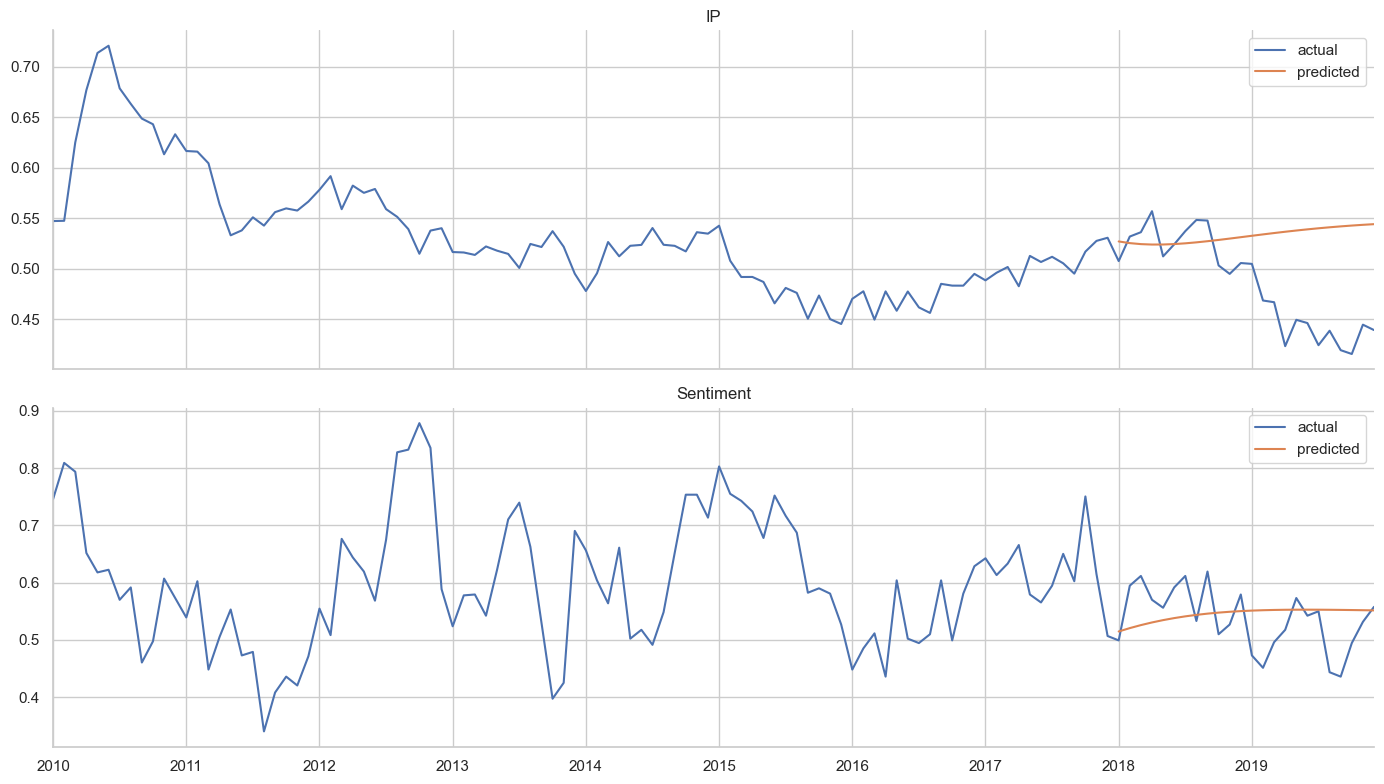

In [26]:
fig, axes = plt.subplots(nrows=2, figsize=(14, 8), sharex=True)

df_transformed['2010':].ip.plot(ax=axes[0], label='actual', title='IP')
preds.ip.plot(label='predicted', ax=axes[0])
axes[0].legend()

df_transformed['2010':].sentiment.plot(ax=axes[1], label='actual', title='Sentiment')
preds.sentiment.plot(label='predicted', ax=axes[1])
axes[1].legend()
axes[1].set_xlabel('')
sns.despine()
fig.tight_layout();

In [27]:
mean_absolute_error(forecast, df_transformed.iloc[492:])

0.05202464525057714